# Import Packages + Create Dataset

In [72]:
# Import needed packages

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline


%matplotlib inline

In [277]:
# Set up graph style

sns.set_theme(context='notebook', palette="Set2", style='white', font='sans-serif', font_scale = 1, color_codes=True, rc={'figure.figsize':(8,8)})

In [74]:
# Import Training Data (Training_Set Features and Training_Set Labels)
cwd = Path.cwd()
parent = cwd.parent

training_set_features = pd.read_csv(parent/'data/training_set_features.csv')
training_set_labels = pd.read_csv(parent/'data/training_set_labels.csv')

In [91]:
# Merge training_set_features with training_set_labels to create a full training_set_df

df = pd.merge(training_set_features, training_set_labels,  how='inner', on='respondent_id')

In [76]:
# Copy of df, in case:

df2 = df.copy()

In [77]:
# Examine full dataset & available variables. 
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

**First glance observations:**

1. *Outcome Variable:* Seasonal_Vaccine (whether or not an individual got the seasonal flu vaccine)


2. Significant amount of missing data for: <br>
health_insurance, <br>
employment_industry & employment_occupation (not actually missing, NaN = not employed)


3. Irrelevant variables: Respondent ID + all variables solely related to H1N1 vaccine (only focusing on the flu vaccine). 



<b>Variables to be removed from dataset:</b> 
* respondent_id, h1n1_vaccine, h1n1_concern, h1n1_knowledge, doctor_recc_h1n1, opinion_h1n1_vacc_effective, opinion_h1n1_risk, opinion_h1n1_sick_from_vacc

In [92]:
# Remove irrelevant variables from dataset

df.drop(['respondent_id', 'h1n1_vaccine', 'h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc'], axis=1, inplace=True)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   behavioral_antiviral_meds    26636 non-null  float64
 1   behavioral_avoidance         26499 non-null  float64
 2   behavioral_face_mask         26688 non-null  float64
 3   behavioral_wash_hands        26665 non-null  float64
 4   behavioral_large_gatherings  26620 non-null  float64
 5   behavioral_outside_home      26625 non-null  float64
 6   behavioral_touch_face        26579 non-null  float64
 7   doctor_recc_seasonal         24547 non-null  float64
 8   chronic_med_condition        25736 non-null  float64
 9   child_under_6_months         25887 non-null  float64
 10  health_worker                25903 non-null  float64
 11  health_insurance             14433 non-null  float64
 12  opinion_seas_vacc_effective  26245 non-null  float64
 13  opinion_seas_ris

# Data Cleaning + Exploratory Data Analysis

## Missing Data

First, let's look at variables with >10% missing data. Worth keeping or dropping?


In [94]:
# create list for >10% missing data columns
gap_cols = []

for col in df.columns:
    if df[col].isna().sum() > 0.1* len(df.index):
        gap_cols.append(col)

print("Columns with >10% missing data:")
gap_cols

    

Columns with >10% missing data:


['health_insurance',
 'income_poverty',
 'employment_industry',
 'employment_occupation']

In [95]:
# Examining Value Counts of large data gap columns

for col in gap_cols:
    print(df[col].value_counts(normalize=True, dropna = False))
    print("\n")


1.0    0.475418
NaN    0.459580
0.0    0.065002
Name: health_insurance, dtype: float64


<= $75,000, Above Poverty    0.478414
> $75,000                    0.254989
NaN                          0.165612
Below Poverty                0.100985
Name: income_poverty, dtype: float64


NaN         0.499120
fcxhlnwr    0.092410
wxleyezf    0.067548
ldnlellj    0.046093
pxcmvdjn    0.038829
atmlpfrs    0.034673
arjwrbjb    0.032613
xicduogh    0.031864
mfikgejo    0.022990
vjjrobsf    0.019733
rucpziij    0.019583
xqicxuve    0.019134
saaquncn    0.012656
cfqqtusy    0.012169
nduyfdeo    0.010709
mcubkhph    0.010297
wlfvacwt    0.008050
dotnnunm    0.007526
haxffmxo    0.005542
msuufmds    0.004643
phxvnwax    0.003332
qnlwzans    0.000487
Name: employment_industry, dtype: float64


NaN         0.504362
xtkaffoo    0.066574
mxkfnird    0.056502
emcorrxb    0.047553
cmhcxjea    0.046692
xgwztkwe    0.040514
hfxkjkmi    0.028682
qxajmpny    0.020519
xqwwgdyp    0.018160
kldqjyjy    0.017561
uqqt

* Income Poverty: Retain; only 16% of the data is missing & processing pipeline includes imputation.

* Data dictionary indicates employment_industry and employment_occupation are not actually missing. The missing data is because the question was only asked if employment status = "Employed"
  * We will impute "Not Employed" in place for anyone who reported Not Employed
  
* Health Insurance --> 45% missing, no indication as to why. Classes are incredibly imbalanced. Therefore, might be best to drop and not impute.

In [96]:
# Double checking that every Not Employed person has a NA value for industry & occupation:
print(df[df['employment_status'] != 'Employed']['employment_industry'].value_counts(dropna=False))
print(df[df['employment_status'] != 'Employed']['employment_occupation'].value_counts(dropna=False))

NaN    13147
Name: employment_industry, dtype: int64
NaN    13147
Name: employment_occupation, dtype: int64


In [101]:
# Replacing 'Not Employed' for relevant rows in employment industry & employment_occupation

df['employment_industry'].mask((df['employment_status'] != 'Employed'), 'Not Employed', inplace=True)

In [105]:
df['employment_occupation'].mask((df['employment_status'] != 'Employed'), 'Not Employed', inplace=True)

In [107]:
# Dropping health_insurance, employment_industry and employment_occupation

df.drop(['health_insurance'], axis=1, inplace=True)

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   behavioral_antiviral_meds    26636 non-null  float64
 1   behavioral_avoidance         26499 non-null  float64
 2   behavioral_face_mask         26688 non-null  float64
 3   behavioral_wash_hands        26665 non-null  float64
 4   behavioral_large_gatherings  26620 non-null  float64
 5   behavioral_outside_home      26625 non-null  float64
 6   behavioral_touch_face        26579 non-null  float64
 7   doctor_recc_seasonal         24547 non-null  float64
 8   chronic_med_condition        25736 non-null  float64
 9   child_under_6_months         25887 non-null  float64
 10  health_worker                25903 non-null  float64
 11  opinion_seas_vacc_effective  26245 non-null  float64
 12  opinion_seas_risk            26193 non-null  float64
 13  opinion_seas_sic

## Exploring Variable Categories/Coding

In [304]:
for col in df.select_dtypes(object).columns:
    print(df[col].value_counts())
    print("\n")

Female    15858
Male      10849
Name: sex, dtype: int64


Married        13555
Not Married    11744
Name: marital_status, dtype: int64


Own     18736
Rent     5929
Name: rent_or_own, dtype: int64


65+ Years        6843
55 - 64 Years    5563
45 - 54 Years    5238
18 - 34 Years    5215
35 - 44 Years    3848
Name: age_group, dtype: int64


College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
Name: education, dtype: int64


White                21222
Black                 2118
Hispanic              1755
Other or Multiple     1612
Name: race, dtype: int64


<= $75,000, Above Poverty    12777
> $75,000                     6810
Below Poverty                 2697
Name: income_poverty, dtype: int64


Employed              13560
Not in Labor Force    10231
Unemployed             1453
Name: employment_status, dtype: int64


lzgpxyit    4297
fpwskwrf    3265
qufhixun    3102
oxchjgsf    2859
kbazzjca    2858
bhuqouqj    2846
mlyzmhmf    2243
lri

In [315]:
# Changing categories for income_poverty and census_msa to be less lengthy:

income_cat = dict(zip(list(df['income_poverty'].value_counts().index), ['Mid', 'High', 'Low'],))

df['income_poverty'].replace(income_cat, inplace=True)

In [317]:
old = list(df['census_msa'].value_counts().index)

old

['MSA, Not Principle  City', 'MSA, Principle City', 'Non-MSA']

In [321]:
new = ['MSA-NPC', 'MSA-PC', 'Non-MSA']

df['census_msa'].replace(old, new, inplace=True)

## Feature Engineering

1. Behavioral Composite
    * Combine all 7 behavioral variables into a variable representing "Flu Behavioral Conscientiousness"


2. Opinion Composite
    * Combine all 3 opinion variables into a variable representing "Pro-Vaccine Attitude"

* df --> 1st dataset will not include feature engineering
* df2 --> 2nd dataset will only have feature engineered variables (remove the variables calculated from it)
* df3 --> 3rd dataset include both

In [110]:
df3 = df.copy()

In [111]:
df3['behavioral_comp'] = df3[list(df.columns)[:7]].sum(axis=1)

df3['opinion_comp'] = df3['opinion_seas_vacc_effective'] + df3['opinion_seas_risk'] + (6 - df3['opinion_seas_sick_from_vacc'])

In [112]:
df3['opinion_comp'].value_counts()

10.0    5784
11.0    5317
12.0    2973
14.0    2311
13.0    2283
8.0     2219
9.0     1861
7.0     1437
15.0     922
6.0      455
5.0      257
4.0      167
3.0      114
Name: opinion_comp, dtype: int64

In [113]:
df2 = df3.copy()

In [114]:
# Remove individual variables from dataset

drop_col = list(df2.columns)[:7] + list(df2.columns)[11:14]
drop_col

df2.drop(drop_col, axis=1, inplace=True)

In [115]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   doctor_recc_seasonal   24547 non-null  float64
 1   chronic_med_condition  25736 non-null  float64
 2   child_under_6_months   25887 non-null  float64
 3   health_worker          25903 non-null  float64
 4   age_group              26707 non-null  object 
 5   education              25300 non-null  object 
 6   race                   26707 non-null  object 
 7   sex                    26707 non-null  object 
 8   income_poverty         22284 non-null  object 
 9   marital_status         25299 non-null  object 
 10  rent_or_own            24665 non-null  object 
 11  employment_status      25244 non-null  object 
 12  hhs_geo_region         26707 non-null  object 
 13  census_msa             26707 non-null  object 
 14  household_adults       26458 non-null  float64
 15  ho

In [116]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   behavioral_antiviral_meds    26636 non-null  float64
 1   behavioral_avoidance         26499 non-null  float64
 2   behavioral_face_mask         26688 non-null  float64
 3   behavioral_wash_hands        26665 non-null  float64
 4   behavioral_large_gatherings  26620 non-null  float64
 5   behavioral_outside_home      26625 non-null  float64
 6   behavioral_touch_face        26579 non-null  float64
 7   doctor_recc_seasonal         24547 non-null  float64
 8   chronic_med_condition        25736 non-null  float64
 9   child_under_6_months         25887 non-null  float64
 10  health_worker                25903 non-null  float64
 11  opinion_seas_vacc_effective  26245 non-null  float64
 12  opinion_seas_risk            26193 non-null  float64
 13  opinion_seas_sic

## Exploratory Analyses

### Comparing Percentage of People who were Vaccinated vs. Not

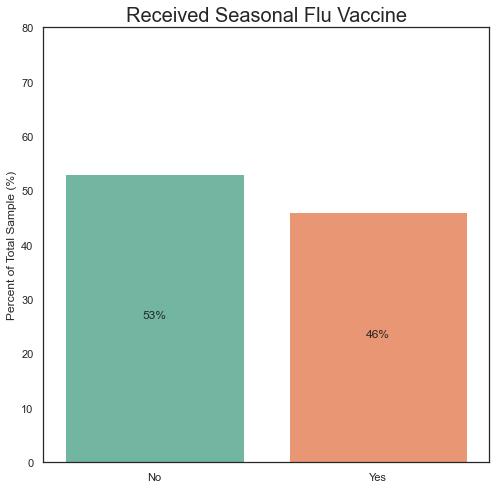

In [278]:
percent = list((df['seasonal_vaccine'].value_counts(normalize=True).values*100).astype(int))

vax = sns.barplot(x = ['No', 'Yes'], y = percent)
vax.set_ylabel("Percent of Total Sample (%)")
vax.set_ylim(0, 80)
vax.set_title('Received Seasonal Flu Vaccine', fontsize=20);

for loc, label in enumerate(percent):
    vax.text(loc, label/2, (str(int(round(label, ndigits=0))) + '%'), ha='center');

### Relationships between individual variables and seasonal_vaccine

In [295]:
graph_df = df.copy()

cat_cols = list(graph_df.select_dtypes(object).columns)

graph_df[cat_cols] = graph_df[cat_cols].apply(lambda x : pd.factorize(x)[0])

In [296]:
graph_df.drop('seasonal_vaccine', axis=1, inplace=True)

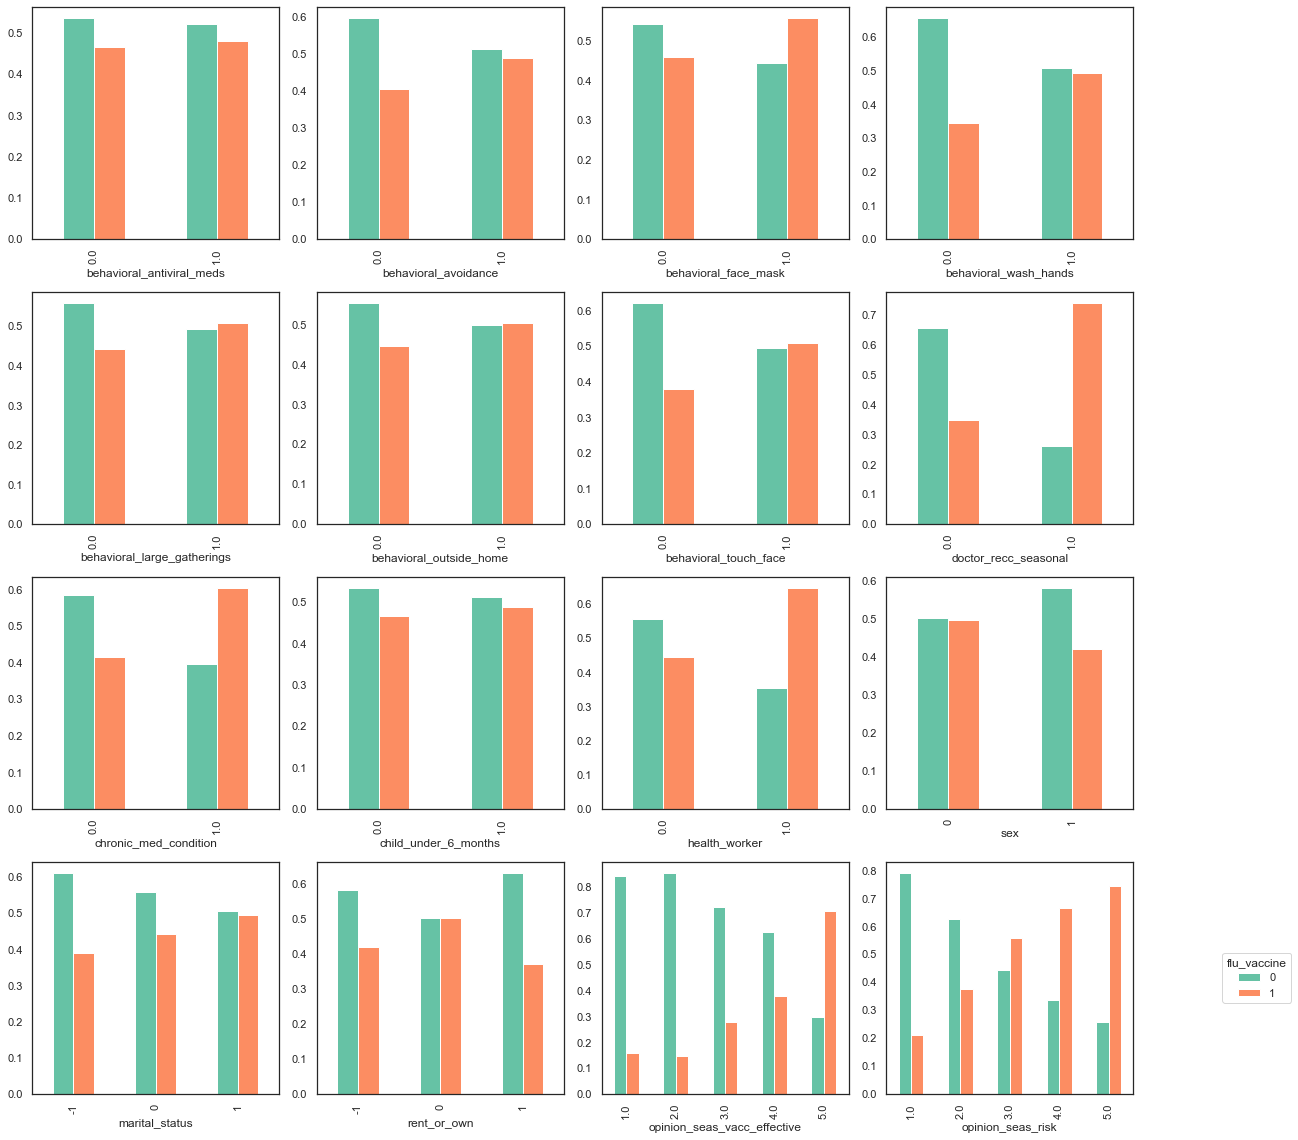

In [297]:
fig, ax = plt.subplots(4,4, figsize=(16,16))

for i, col in enumerate(graph_df.columns[0:16]):
    x = i//4
    y = i%4
    pd.crosstab(graph_df[col], df['seasonal_vaccine'], normalize='index').plot(kind='bar', ax=ax[x][y], legend=False)

plt.tight_layout()
plt.legend(
    loc='center', 
    bbox_to_anchor=(1.5, 0.5), 
    title='flu_vaccine'
);

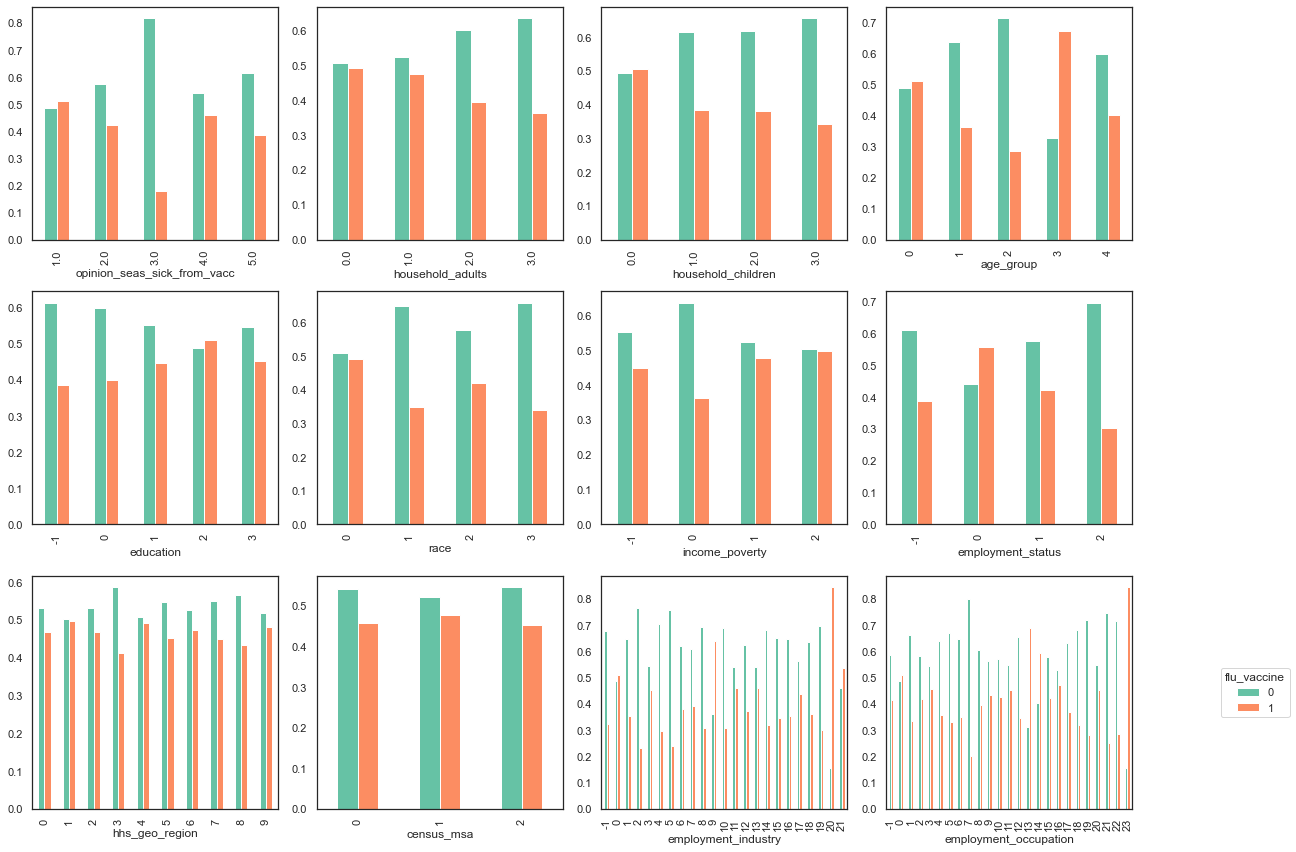

In [299]:
fig, ax = plt.subplots(3,4, figsize=(16,12))

for i, col in enumerate(df_int.columns[16:]):
    x = i//4
    y = i%4
    pd.crosstab(df_int[col], df['seasonal_vaccine'], normalize='index').plot(kind='bar', ax=ax[x][y], legend=False)

plt.tight_layout()
plt.legend(
    loc='center', 
    bbox_to_anchor=(1.5, 0.5), 
    title='flu_vaccine'
);

# Data Preparation + Pipelines

In [323]:
# Separate X, y

X = df.drop('seasonal_vaccine', axis=1)
y = df['seasonal_vaccine']

In [324]:
# Train-test split before pipelines

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Data Preprocessing Pipelines by Variable Type

In [325]:
# Num Pipe
num_pipe = Pipeline([
    ('num_impute', SimpleImputer(strategy='mean')),
    ('ss', StandardScaler()),
])

In [326]:
# Cat Pipeline

cat_pipe = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [327]:
# Column Transformer

CT = ColumnTransformer(transformers=[
    ('num_tr', num_pipe, selector(dtype_include=np.number)),
    ('cat_tr', cat_pipe, selector(dtype_include=object)),
], remainder='passthrough')

## ModelWithCV Function:

In [328]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

# Preliminary Models

## Dummy Model

In [330]:
dummy_model = Pipeline([
    ('ct', CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [331]:
dummy_model_pipe = ModelWithCV(dummy_model, model_name = 'dummy', X=X_train, y=y_train)

In [333]:
dummy_model_pipe

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_tr',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbfe362e340>),
                                                 ('cat_tr',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   One

CV Results for `dummy` model:
            0.53110 ± 0.00020 accuracy
        


<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

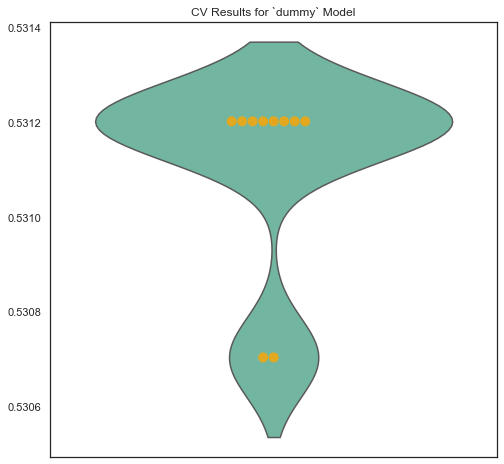

In [334]:
dummy_model_pipe.print_cv_summary()

fig, ax = plt.subplots()

dummy_model_pipe.plot_cv(ax=ax)

## First Simple Model

In [36]:
logreg = Pipeline([
    ('ct',CT),
    ('logreg', LogisticRegression(random_state=42))
])

logreg.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_tr',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f92509efaf0>),
                                                 ('cat_tr',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   One

In [37]:
fsm_model_pipe = ModelWithCV(logreg, model_name = 'fsm', X=X_train, y=y_train)

In [38]:
y_pred = logreg.predict(X_test)

In [39]:
cf_matrix = confusion_matrix(y_test, y_pred)


In [40]:
cf_matrix

array([[2926,  708],
       [ 821, 2222]])

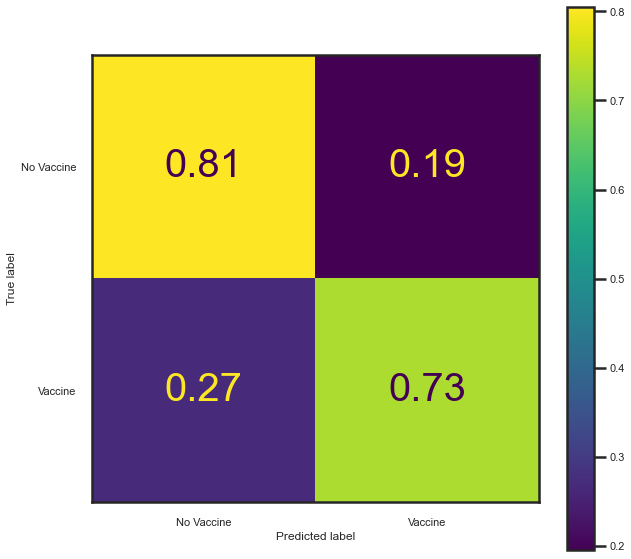

In [41]:
plot_confusion_matrix(logreg, X_test, y_test, display_labels = ['No Vaccine', 'Vaccine'], normalize='true');

CV Results for `fsm` model:
            0.76281 ± 0.01406 accuracy
        


<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

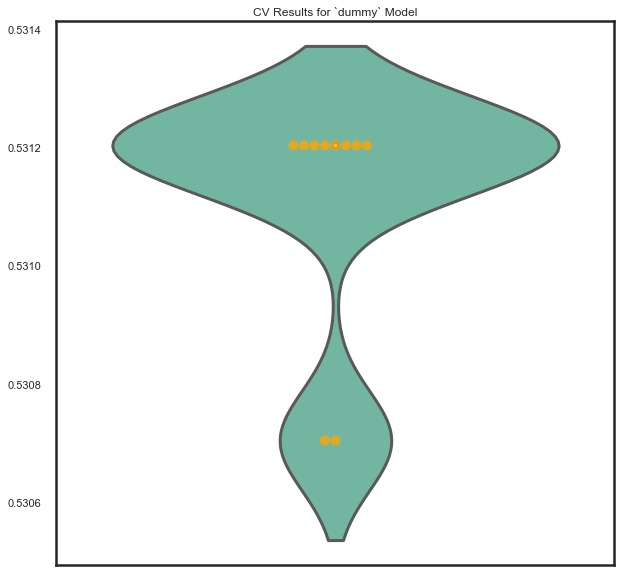

In [42]:
fsm_model_pipe.print_cv_summary()

fig, ax = plt.subplots()

dummy_model_pipe.plot_cv(ax=ax)

## Random Forest Model

,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,seasonal_vaccine,behavioral_comp,opinion_comp,household
0,0.0,0.0,0.0,0.0,55 - 64 Years,< 12 Years,White,Female,1.0,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0,2.0,7.0,0.0
1,0.0,0.0,0.0,0.0,35 - 44 Years,12 Years,White,Male,1.0,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",1,4.0,8.0,0.0
2,NaN,1.0,0.0,0.0,18 - 34 Years,College Graduate,White,Male,2.0,Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",0,1.0,9.0,2.0
3,1.0,1.0,0.0,0.0,65+ Years,12 Years,White,Female,1.0,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",1,3.0,14.0,0.0
4,0.0,0.0,0.0,0.0,45 - 54 Years,Some College,White,Female,2.0,Married,Own,Employed,qufhixun,"MSA, Not Principle City",0,4.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,0.0,0.0,0.0,0.0,65+ Years,Some College,White,Female,2.0,Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0,2.0,11.0,0.0
26703,1.0,0.0,0.0,1.0,18 - 34 Years,College Graduate,White,Male,2.0,Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",0,2.0,11.0,1.0
26704,0.0,0.0,0.0,0.0,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",1,5.0,13.0,0.0
26705,0.0,0.0,0.0,0.0,18 - 34 Years,Some College,Hispanic,Female,2.0,Married,Rent,Employed,lrircsnp,Non-MSA,0,0.0,7.0,1.0


In [43]:
rfc = RandomForestClassifier(random_state=42)

rfc_model_pipe = Pipeline([
    ('ct', CT),
    ('rfc', rfc)
])

forest_pipe = ModelWithCV(model=rfc_model_pipe,
                         model_name="forest_pipe",
                         X=X_train,
                          y=y_train)

#forest_pipe.fit(X_train, y_train)




NameError: name 'forest_pip' is not defined

In [44]:
forest_pipe.print_cv_summary()

CV Results for `forest_pipe` model:
            0.75397 ± 0.01279 accuracy
        


In [ ]:
forest_pipe.score(X_test_sc)